In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.io import FortranFile
from cobaya.model import get_model
import yaml
import os
from getdist import plots, MCSamples

In [2]:
getdist_settings = {
    'smooth_scale_1D': 0.3,
    'smooth_scale_2D': 0.4,
    'boundary_correction_order': 1,
    'mult_bias_correction_order': 1,
    }

In [3]:
dataset_path = "/home/afarina/cobaya_likelihoods/data/planck_2018_pliklite_native/cl_cmb_plik_v22.dat"

planck_dat = np.genfromtxt(dataset_path)

In [4]:
planck_dat

array([[ 3.20000000e+01,  6.52720153e+00,  6.93104790e-01],
       [ 3.70000000e+01,  5.27440733e+00,  5.18730810e-01],
       [ 4.20000000e+01,  4.96452185e+00,  4.08305720e-01],
       ...,
       [ 1.95400000e+03, -7.02871522e-05,  3.52293228e-05],
       [ 1.97100000e+03,  8.39452374e-05,  3.63386423e-05],
       [ 1.98800000e+03,  8.39771223e-06,  3.75763001e-05]])

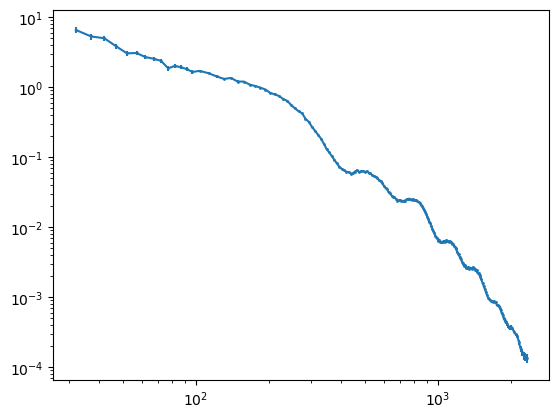

In [5]:
plt.errorbar(planck_dat[:210, 0], planck_dat[:210, 1], yerr = planck_dat[:210, 2], marker='o', ms = 1 )
plt.xscale('log')
plt.yscale('log')

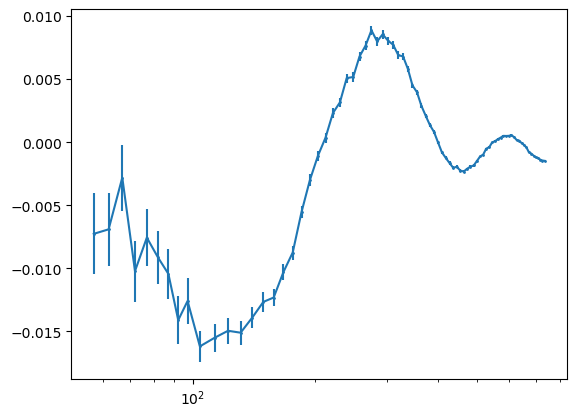

In [6]:
plt.errorbar(planck_dat[220:300, 0], planck_dat[220:300, 1], yerr = planck_dat[220:300, 2], marker='o', ms = 1 )
plt.xscale('log')
# plt.yscale('log')

## ACT

In [7]:
yaml_path = "/home/afarina/ParametricModels/LCDM/chains/01p3_LCDM_CMB_ACTTTTEEE.input.yaml"

In [8]:
# define the path to the YAML parameters file:
yaml_params = yaml_path #os.path.join(chains_dir, name + '.input.yaml')
# load the parameters from the YAML file:
with open(yaml_params, 'r') as f:
    params_dict = yaml.safe_load(f)
# remove the 'path' key from the 'camb' dictionary if it exists:
if 'path' in params_dict.get('theory', {}).get('camb', {}):
    del params_dict['theory']['camb']['path']
if 'recombination_model' in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['recombination_model']

# build the model:
model = get_model(params_dict)

[model] *WARNING* Ignored blocks/options: ['sampler', 'output']
[camb] `camb` module loaded successfully from /home/afarina/anaconda3/envs/nbase/lib/python3.12/site-packages/camb


In [9]:
ACT_datavector = model.components[0].data_vec

In [10]:
ACT_covmat = model.components[0].covmat

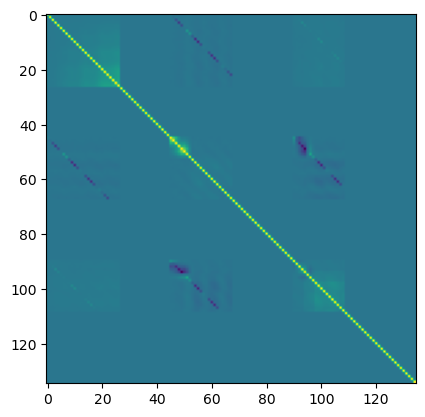

In [11]:
ACT_corr = ACT_covmat / np.outer( np.sqrt(np.diag(ACT_covmat)), np.sqrt(np.diag(ACT_covmat)))

plt.imshow(ACT_corr)

In [12]:
chains_dir = os.path.join('chains')

# import chain
from cobaya import load_samples

name = '01p3_LCDM_CMB_ACTTTTEEE'
chain = load_samples(os.path.join(chains_dir, name), skip=0.3, to_getdist=True)
chain.label = name
chain.root = os.path.join(chains_dir, name)
chain.updateSettings(getdist_settings)
chain.updateBaseStatistics()
chain.getConvergeTests()
print(chain.label+': R =', round(chain.GelmanRubin, 4))

[samplecollection] Loaded 3906 sample points from 'chains/01p3_LCDM_CMB_ACTTTTEEE.1.txt'
[samplecollection] Loaded 4377 sample points from 'chains/01p3_LCDM_CMB_ACTTTTEEE.2.txt'
[samplecollection] Loaded 4388 sample points from 'chains/01p3_LCDM_CMB_ACTTTTEEE.3.txt'
[samplecollection] Loaded 4003 sample points from 'chains/01p3_LCDM_CMB_ACTTTTEEE.4.txt'
01p3_LCDM_CMB_ACTTTTEEE: R = 0.0113


In [15]:
params = model.parameterization.sampled_params()
print(params)

{'H0': nan, 'logA': nan, 'ns': nan, 'ombh2': nan, 'omch2': nan, 'tau': nan, 'A_act': nan, 'P_act': nan}


In [18]:
BestFit = chain.getBestFit()
BestFitDict = BestFit.getParamDict()

In [19]:
for p in params.keys():
    params[p] = BestFitDict[p]  # Set the best fit values for all parameters

In [39]:
model.provider.set_current_input_params(params)

In [42]:
params

{'H0': 66.42692131,
 'logA': 3.081837641,
 'ns': 0.9582737019,
 'ombh2': 0.022511084,
 'omch2': 0.1228062405,
 'tau': 0.0686002691,
 'A_act': 0.9999954061,
 'P_act': 1.002060203}

In [22]:
cls = model.provider.get_Cl(ell_factor=True)
# print("TT Cl[2] =", cls["tt"][2])

[camb] *ERROR* Cannot retrieve calculated quantities: nothing has been computed yet (maybe the prior was -infinity?)
[camb] *ERROR* No lensed Cl's were computed. Are you sure that you have requested them?


LoggedError: No lensed Cl's were computed. Are you sure that you have requested them?

## Planck High-L

In [3]:
#### function for cutting Planck l-values in order to match with those of ACT

import numpy as np
from cobaya.likelihoods.base_classes import PlanckPlikLite

cl_names = ["tt", "te", "ee"]


class PlanckActCut(PlanckPlikLite):
    """
    A simple Planck likelihood that cuts the data above a certain ell value.
    This is intended to be used to combine Planck with ACT DR6, including
    the Planck low-ell data.

    Author: Hidde T. Jense
    """
    def init_params(self, ini):
        super().init_params(ini)

        ix = 0
        uses = {}
        for xy, lmin, lmax in zip(ini.list('use_cl'),
                                  ini.int_list('lmin_cuts'),
                                  ini.int_list('lmax_cuts')):
            idx = self.used_bins[cl_names.index(xy)]

            mask = np.logical_or(self.blmin[idx] < lmin,
                                 self.blmax[idx] > lmax)
            to_cut = idx[mask] + ix

            self.cov[to_cut, :] = 0.0
            self.cov[:, to_cut] = 0.0
            self.cov[to_cut, to_cut] = 1e10

            self.log.debug(f"Cutting bins {to_cut}")

            self.log.debug(f"Removing bins {to_cut} in {xy.upper()}.")

            ix += len(idx)
            if len(idx) > len(to_cut):
                uses[xy] = len(idx) - len(to_cut)

        self.invcov = np.linalg.inv(self.cov)

        self.log.debug(f"Using a total of {ix} bins.")
        self.log.debug("Breakdown:")
        for i, k in uses.items():
            self.log.debug(f"\t{i.upper()}: {k}")


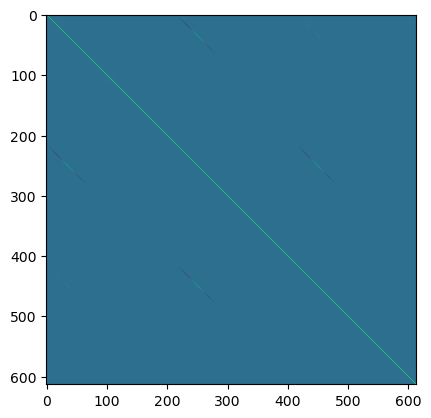

In [99]:
Planck_hl_cov = model.components[0].cov
Planck_hl_corr = Planck_hl_cov / np.outer( np.sqrt(np.diag(Planck_hl_cov)),  np.sqrt(np.diag(Planck_hl_cov)))

plt.imshow(Planck_hl_corr)

In [129]:
model.components[0].__dict__

{'delay': 0,
 '_measured_speed': None,
 '_name': 'act_dr6_cmbonly.PlanckActCut',
 'packages_path': '/home/afarina/cobaya_likelihoods',
 'path': '/home/afarina/cobaya_likelihoods/data/planck_2018_pliklite_native',
 'dataset_file': 'plik_lite_v22.dataset',
 'dataset_params': {'use_cl': 'tt te ee',
  'lmin_cuts': '0 0 0',
  'lmax_cuts': '1000 600 600'},
 'aliases': ['plikHM_TTTEEE'],
 'speed': 200,
 'params': {'A_planck': {'prior': {'dist': 'norm', 'loc': 1, 'scale': 0.0025},
   'ref': {'dist': 'norm', 'loc': 1, 'scale': 0.002},
   'proposal': 0.0005,
   'latex': 'y_\\mathrm{cal}',
   'renames': 'calPlanck'}},
 'type': 'CMB',
 'stop_at_error': False,
 'version': None,
 'log': <Logger act_dr6_cmbonly.planckactcut (INFO)>,
 'timer': None,
 'dataset_filename': '/home/afarina/cobaya_likelihoods/data/planck_2018_pliklite_native/plik_lite_v22.dataset',
 'use_cl': ['tt', 'te', 'ee'],
 'calibration_param': 'A_planck',
 'blmin': array([  30,   35,   40,   45,   50,   55,   60,   65,   70,   75,   

In [102]:
Planck_hl_X = model.components[0].X_data

In [4]:
#### path to covariance

cov_path = "/home/afarina/cobaya_likelihoods/data/planck_2018_pliklite_native/c_matrix_plik_v22.dat"

In [6]:
nbins = 613  

f = FortranFile(cov_path, 'r')
cov = f.read_reals(dtype=float).reshape((nbins, nbins))
cov = np.tril(cov) + np.tril(cov, -1).T  # make symmetric

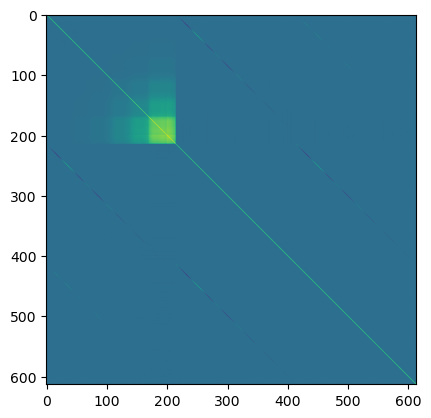

In [7]:
corr = cov / np.outer( np.sqrt(np.diag(cov)), np.sqrt(np.diag(cov)))

plt.imshow(corr)

## BAO